<a href="https://colab.research.google.com/github/JuanmaPastor/CSC_IC50/blob/main/ICmetrics_inputs_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive ##
drive.mount('/content/drive')  ## Choose the Google account whose Drive you want to mount --> "Sign in to Google Drive for desktop" --> "Make sure you trust Google Drive for desktop" (you must allow Google Drive to access your data for use in the program)
%cd 'drive/MyDrive/Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


## If you want to upload a file ran the following cell

In [2]:
from google.colab import files
uploaded = files.upload()


In [ ]:
%ls ## check that your data file is located in this directory

 01_eda_with_python.ipynb
 02_regression_with_python.ipynb
 1982NSFGData.dat.gz
 1995FemRespData.dat.gz
 2002FemPreg.dat.gz
 2002FemPreg.dct
 2002FemResp.dat.gz
 2002FemResp.dct
 2002Male.dat.gz
 2002Male.dct
 2006_2010_FemPreg.dat.gz
 2006_2010_FemPregSetup.dct
 2006_2010_FemResp.dat.gz
 2006_2010_FemRespSetup.dct
 2006_2010_Male.dat.gz
 2006_2010_MaleSetup.dct
 2011_2013_FemPregData.dat.gz
 2011_2013_FemPregSetup.dct
 2011_2013_FemRespData.dat.gz
 2011_2013_FemRespSetup.dct
 2011_2013_MaleData.dat.gz
 2011_2013_MaleSetup.dct
 analytic.py
 Apr25_27thAn_set1.shtml
 Aula_1bach@
 babyboom.dat
'Basic_Plotting (1).ipynb'
 Basic_Plotting.ipynb
 brfss.py
 build.sh
'Carrera de tortugas.ipynb'
 CDBRFS08.ASC.gz
 CDBRFS08ASC.ZIP
 chap01ex.ipynb
 chap01ex.py
 chap01soln.py
 chap02ex.ipynb
 chap02ex.py
 chap02soln.py
 chap03ex.ipynb
 chap03soln.py
 chap04ex.ipynb
 chap05ex.ipynb
 chap06ex.ipynb
 chap06soln.py
 chap07ex.ipynb
 chap07soln.py
 chap08ex.ipynb
 chap08soln.py
 chap09ex.ipynb
 chap09soln

In [3]:
filename = input("Excel filename:")

Excel filename:data_example_growth_rates.xlsx


In [4]:
n_times_str= input("Number of time points:")

Number of time points:4


In [5]:
n_exp_str = input("Number of experiments per time point:")

Number of experiments per time point:9


In [6]:
time_IC50_str = input("Time point for IC50 calculation:")

Time point for IC50 calculation:3


## Now from "Runtime" menu you can select "*Run cell and below*"




# IC50, ICr0, ICrmed Estimation via Bootstrapping and MC Techniques

By Juan Manuel Pastor Ruiz and Paula Romero Jiménez

Date: September 2024

## Overview

This script uses a robust statistical approach involving bootstrapping and Monte Carlo simulations to estimate key parameters like IC50, ICr0, and ICrmed from biological data. The resampling is done under the assumption of a normal distribution for error propagation, ensuring more accurate confidence intervals and insights into variability.

It builds on the previous data obtained in `growth_rate_bootstrapping.ipynb`. This is an Excel file with the concentration data, calculated growth rates and their errors.

## Table of Contents
1. [Import Libraries](##import-libraries)
2. [Model Background](##model-background)
3. [Define Functions](##define-functions)
4. [Usage](##usage)

## 1. Import Libraries

In [7]:
# Import necessary libraries

# Data organization
import pandas as pd
import numpy as np

# Data visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Modeling
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy import stats

## 2. Model Background

We are modeling the growth rate as a function of drug concentration, assuming an exponential decay in the growth rate with increasing concentration.

### Exponential Decay of Growth Rate:

The growth rate, $r_q(C)$, at a given concentration $C$, can be modeled as an exponential function:

$$r_q(C) =  A·e^{-\alpha C} - r_{\infty} \;\; (Eq.1)$$

where:

- $r_{\infty}$ is the growth rate at infinite drug concentration (a positive constant)
- $A$ is an amplitude term related to the initial growth rate at zero concentration
- $\infty$ is the decay rate of the growth rate as the concentration increases

For concentration $C = 0$, the growth rate is:

$$r_q(C = 0) = r_{Control} = r_{C0} = A - r_{\infty}$$

which gives:
$$A = r_{C0} + r_{\infty}$$

Substituting this into the equation for $r_q(C)$, we obtain:

$$r_q(C) =  (r_{C0}+r_{\infty})·e^{-\alpha C} - r_{\infty} \;\; (Eq.2) $$


### To calculate IC50:

The IC50 value is the drug concentration at which the viability is 50%. Viability is calculated from the growth rate using the following equation:

$$V(t)=\frac{N_q (t)}{N_0 (t)} = \frac{N_{0}'}{N_0}e^{(r_{q} - r_{C0})·t}$$

where:
- $N_q(t)$ is the population size at concentration C
- $N_0(t)$ is the control population size
- $r_{q}$ is the growth rate at concentration C
- $r_{C0}$ is the control growth rate (without the drug)
- $t$ is the time.

For a viability $V(t) = 0.5$ (which corresponds to IC50):

$$V_{IC50}(t) = 0.5 = \frac{N_0'}{N_0}e^{(r_{IC50} - r_{C0})·t} \;\; (Eq.3) $$

then:

$$r_{IC50} = r_{C0}+\frac{ln(0.5)-ln(N_0'/N_0)}{t}$$

From Eq(2), we can express the concentration at IC50:

$$C(IC50) = \frac{-1}{\alpha} ln \left(\frac{r_{IC50} + r_{\infty}}{r_{C0} + r_{\infty}} \right)$$

Using the fit parameters from the model:

$$C(IC50) = \frac{-1}{b_{fit}} ln \left(\frac{r_{IC50} + c_{fit}}{a_{fit}} \right)$$

### To calculate ICr0:

The ICr0 (or IC(r=0)) is the drug concentration at which the growth rate becomes zero, meaning that the population stops growing completely.

To calculate the drug concentration at which the growth rate is zero, we set $r=0$ in Eq(2):

$$0 = (r_{C0}+r_{\infty})e^{-\alpha C(r=0)} - r_{\infty}$$

$$C(r=0)=\frac{-1}{\alpha}ln \left(\frac{r_{\infty}}{r_{C0}+r_{\infty}} \right) $$



## 3. Define Functions

`f_exponen_shift`: Exponential function used for curve fitting.

In [8]:
def f_exponen_shift(x, a, b, c):
    """
    Negative exponential function of the form : y = a * exp(-b * x) - c

    Parameters:
    x : input value
    a, b, c : parameters of the exponential function (c > 0)

    Returns:
    The value of the exponential function evaluated at x
    """
    return a * np.exp(-b * x) - c

`f_exponen_shift_inv`: Inverse exponential function used to estimate IC50.

In [9]:
def f_exponen_shift_inv(y, a, b, c):
    """
    Inverse of the negative exponential function of the form: y = a * exp(-b * x) - c
    Rearranged form: x = -1/b * ln((y + c)/a)

    Parameters:
    y : input value
    a, b, c : parameters of the exponential function (c > 0)

    Returns:
    The value of x that corresponds to a given y in the exponential function.
    """
    if (y+c)/a >0:
        return -1./b * np.log( (y+c)/a )
    else:
        return 1e10

`ICmetrics_estimation`: This function calculates key metrics like IC50, ICr0, and ICrmed using a Bootstrap Monte Carlo approach, where values are randomly sampled from a normal distribution, and an exponential model is fitted.

- IC50: The concentration of a drug where the response (e.g., growth rate) is reduced by 50% compared to the control.
- ICr0: The concentration where the growth rate drops to zero.
- ICrmed: The concentration where the growth rate is halved compared to the control.

The function iterates by randomly selecting values within the range of ymin to ymax for each concentration, fits a shifted decreasing exponential to the data, and averages the results.

In [10]:
def ICmetrics_estimation(X, y, error_y, n_boot, n_samples_fit_r, t_IC50, name, save=False):
    """
    Estimates IC50, ICr0, and ICrmed using a Bootstrap approach with a normal distribution for error resampling.

    Parameters:
    - X: Array of drug concentrations.
    - y: Array of growth rates at corresponding concentrations.
    - error_y: Array of errors in growth rates (standard deviations).
    - n_boot: Number of bootstrap iterations.
    - n_samples_fit_r: Number of samples used to calculate the t-statistic for confidence intervals.
    - t_IC50: Time point used to compute the IC50.
    - name: File name for saving the plot (if save=True).
    - save: Whether to save the resulting plot (default is False).

    Returns:
    - IC50_mean: Mean IC50 value across bootstrap samples.
    - IC50_interval: Confidence interval for IC50.
    - ICr0_mean: Mean ICr0 value across bootstrap samples.
    - ICr0_interval: Confidence interval for ICr0.
    - ICrmed_mean: Mean ICrmed value across bootstrap samples.
    - ICrmed_interval: Confidence interval for ICrmed.
    """

    # Ensure inputs are numpy arrays
    X = np.array(X).ravel()
    y = np.array(y).ravel()
    e = np.array(error_y).ravel()
    print('y',y)

    # Compute key points fro the metrics: r_IC50 and rmed
    r_IC50 = y[0]+np.log(0.5)/t_IC50
    rmed = y[0]/2.
    print('r_IC50:', r_IC50, 'r[0]:', y[0], 'rmed:', rmed)

    # Calculate standard errors using t-distribution
    alpha = 0.05
    t = stats.t.ppf(1-alpha, n_samples_fit_r-2)
    e_std = e/t
    print('t:',t, 'e_std:', e_std)

    # Initialize arrays to store results from each bootstrap iteration
    n_samples = len(X)
    npoints_plot = 1000

    n_param = 3  # for exponential fit parameters (A, B, C)
    y_hat_b = np.zeros((n_boot, n_samples), dtype=float)
    y_plot_b = np.zeros((n_boot, npoints_plot), dtype=float)
    params_b = np.zeros((n_boot, n_param), dtype=float)
    IC50inv_b = np.zeros((n_boot), dtype = float)
    ICr0inv_b = np.zeros((n_boot), dtype = float)
    ICrmedinv_b = np.zeros((n_boot), dtype = float)
    r2_b = np.zeros((n_boot), dtype = float)

    # Set up figure for plotting
    fig = plt.figure(figsize=(18,18))
    gs = GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    # Prepare points for plotting the fitted curve
    X_plot = np.linspace(0, X[-1], npoints_plot)

    # Iterate through bootstrap samples
    i_fit=0
    for i_b in range(n_boot):
        # Generate bootstrap sample by resampling the growth rates with normal error
        y_boot = []
        for j in range(len(X)):
            y_j = np.random.normal(y[j],e_std[j], 1)[0]
            y_boot.append(y_j)

        try:
            # Fit the shifted exponential model: A * exp(-B * X) - C
            popt_b, pcov_b = curve_fit(f_exponen_shift, X, y_boot, bounds=(0, [10,10,10]))
            y_hat_i = f_exponen_shift(X, *popt_b) # Predicted values for the bootstrap fit

            # Residual check and parameter validation
            res_b = y_boot - y_hat_i
            sum_resid = np.abs(res_b).sum()
            all_lt_10 = (np.abs(popt_b)<10).all() and (np.sqrt(pcov_b[2][2])<10) # Parameter check

            if (all_lt_10) and (sum_resid<10):
                # Calculate inverse function
                IC50inv_b[i_fit] = f_exponen_shift_inv(r_IC50, *popt_b)
                ICr0inv_b[i_fit] = f_exponen_shift_inv(0.0, *popt_b)
                ICrmedinv_b[i_fit] = f_exponen_shift_inv(rmed, *popt_b)
                r2_b[i_fit] = r2_score(y_boot, y_hat_i)
                y_hat_b[i_fit,:] = y_hat_i

                if (IC50inv_b[i_fit]<100) and (ICr0inv_b[i_fit]<100) and (ICrmedinv_b[i_fit]<100):
                    params_b[i_fit,:] = popt_b[:]
                    # Plot the current fit (light grey) and scatter the bootstrapped data points
                    y_plot = f_exponen_shift( X_plot, *popt_b)
                    y_plot_b[i_fit,:] = y_plot
                    ax1.plot(X_plot, y_plot, color='grey', alpha=0.1, zorder=1)
                    ax1.scatter(X, y_boot, marker='o', alpha = 0.1, color='orange', zorder=2)

                i_fit += 1
                if (i_b % 100 == 0):
                    print('fit OK, i_b',i_b, ', i_fit:', i_fit)

            else:
                print('\n\n\nWarning: High residuals or large parameters! Sum:', np.abs(res_b).sum(), '\n\n\n')
        except RuntimeError:
            # In case curve fitting fails, skip to the next iteration
            pass

    nfit = i_fit

    # Compute means and intervals for IC metrics
    params_mean = np.mean(params_b[:nfit,:], axis=0)
    IC50inv_mean = np.mean(IC50inv_b[:nfit])
    ICr0inv_mean = np.mean(ICr0inv_b[:nfit])
    ICrmedinv_mean = np.mean(ICrmedinv_b[:nfit])

    # Compute confidence intervals for IC values
    sum_res2_IC50inv = np.sum((IC50inv_b[:nfit] - IC50inv_mean)**2)
    sum_res2_ICr0inv = np.sum((ICr0inv_b[:nfit] - ICr0inv_mean)**2)
    sum_res2_ICrmedinv = np.sum((ICrmedinv_b[:nfit] - ICrmedinv_mean)**2)

    SE_IC50inv = np.sqrt(n_samples/(n_samples-1)) * np.sqrt( sum_res2_IC50inv / (nfit-1)) # 2 degrees of freedom
    SE_ICr0inv = np.sqrt(n_samples/(n_samples-1)) * np.sqrt( sum_res2_ICr0inv / (nfit-1)) # 2 degrees of freedom
    SE_ICrmedinv = np.sqrt(n_samples/(n_samples-1)) * np.sqrt( sum_res2_ICrmedinv / (nfit-1)) ## 2 degrees of freedom

    # Calculate the confidence intervals
    t = stats.t.ppf(1-alpha, n_samples-1)
    Interv_IC50inv = t * SE_IC50inv
    Interv_ICr0inv = t * SE_ICr0inv
    Interv_ICrmedinv = t * SE_ICrmedinv

    print('r[0]:', y[0], ',  r_IC50:', r_IC50, ';  rmed:', rmed)

    print('IC50inv_mean:',IC50inv_mean, 'SE_IC50inv:', SE_IC50inv, 'Interval:', Interv_IC50inv)
    print('ICr0inv_mean:',ICr0inv_mean, 'SE_ICr0inv:', SE_ICr0inv, 'Interval:', Interv_ICr0inv)
    print('ICrmedinv_mean:',ICrmedinv_mean, 'SE_ICrmedinv:', SE_ICrmedinv, 'Interval:', Interv_ICrmedinv)

    ymin_plot, ymax_plot = ax1.get_ylim()
    xmin_plot, xmax_plot = ax1.get_xlim()
    ax1.margins(0.01)

    # Plot the average fit and indicate key metrics on the plot
    yhat_mean = np.mean(y_hat_b, axis=0)
    yplot_mean = np.mean(y_plot_b, axis=0)
    ax1.plot(X_plot, yplot_mean, color='red', label='average_fit')

    yfit_mean = f_exponen_shift(X_plot, params_mean[0], params_mean[1], params_mean[2])
#     ax1.plot(X_plot, yfit_mean, color='green', label='average_params')

    # Plot IC50, ICr0, and ICrmed
    label_IC50 = f'IC50:{IC50inv_mean:.1f}, error:{Interv_IC50inv:.1f} (r_IC50:{r_IC50:.2f})'
    ax1.hlines(y=0, xmin=xmin_plot, xmax=xmax_plot, colors='black')
    ax1.plot([IC50inv_mean, IC50inv_mean], [ymin_plot, r_IC50], 'b:', linewidth=3, label=label_IC50) ##vertical
    ax1.plot([xmin_plot, IC50inv_mean], [r_IC50, r_IC50], 'k:', linewidth=3) ##horizontal

    label_ICrmed = f'ICrmed:{ICrmedinv_mean:.1f}, error:{Interv_ICrmedinv:.1f} (rmed:{rmed:.2f})'
    ax1.plot([ICrmedinv_mean, ICrmedinv_mean], [ymin_plot, rmed], 'm-.' , linewidth=3, label=label_ICrmed) ##vertical
    ax1.plot([xmin_plot, ICrmedinv_mean], [rmed, rmed], 'm-.', linewidth=3) ##horizontal

    label_ICr0 =f'ICr0:{ICr0inv_mean:.1f}, error:{Interv_ICr0inv:.1f}'
    ax1.plot([ICr0inv_mean, ICr0inv_mean], [ymin_plot, 0], 'g--', linewidth=3, label=label_ICr0) ##vertical
    ax1.plot([xmin_plot, ICr0inv_mean], [0,0],  'g--', linewidth=3) ##horizontal

    ax1.set_xlabel('Cisplatin concentration (uM)')
    ax1.set_ylabel('Growth rate (r)')
    ax1.set_title(f'IC50_boot_MC_norm (file: {name}); t:{t_IC50}; n_boot (MC): {n_boot} ')
    ax1.grid(True)
    ax1.legend(loc='best')

    # Statistics histogram
    n_bins=20
    r2_plot = r2_b[:nfit].ravel()

    # Plot R2 distribution
    ax2.hist(r2_plot, density=False, bins=n_bins, range=(r2_plot.min(), r2_plot.max()),histtype='barstacked', rwidth=0.8)
    ax2.set_title('r^2 distribution')

    # Plot IC50 distribution
    ax3.hist(IC50inv_b[:nfit], bins=n_bins, range=(IC50inv_b.min(), IC50inv_b.max()), histtype='barstacked', rwidth=0.8)
    ax3.set_title('IC50 distribution')

    # Save the plot if requested
    if save:
        filename = name + '_IC_metrics.jpg'
        plt.savefig(filename)

    plt.show()

    # Return the calculated mean IC values and their confidence intervals
    return (IC50inv_mean, Interv_IC50inv, ICr0inv_mean, Interv_ICr0inv, ICrmedinv_mean, Interv_ICrmedinv)

## 4. Usage

### Load data

In [11]:
# Load an Excel file that contains the concentration (X0), growth rates (y0), and the associated errors (e).
name = filename.split('.')[0]


df = pd.read_excel(filename)
X0 = df['Concentration']
y0 = df['Growth Rate']
e = df['Error']

In [12]:
df.head(10)

,Unnamed: 0,Concentration,Growth Rate,Error
0,0,0.000000,0.278592,0.062686
1,1,0.097656,0.304434,0.038417
2,2,0.195312,0.274887,0.030651
3,3,0.390625,0.244718,0.031788
4,4,0.781250,0.194771,0.032371
5,5,1.562500,0.144071,0.037439
6,6,3.125000,0.078163,0.025613
7,7,6.250000,-0.013315,0.039402
8,8,12.500000,-0.054185,0.039412
9,9,25.000000,-0.207703,0.062581


### Set parameters for Bootstrapping and Fitting

In [13]:
time_IC50 = float(time_IC50_str)
n_times = int(n_times_str)
n_exp = int(n_exp_str)

n_samples_fit_r = n_times * n_exp  # Total number of samples used for the fit

n_boot = 1000   # Number of bootstrap iterations

### Run Bootstrapping to Estimate IC Values

y [ 0.27859184  0.3044339   0.27488699  0.24471822  0.19477145  0.14407094
  0.07816297 -0.01331537 -0.05418518 -0.20770275 -0.44306615]
r_IC50: 0.04754277725401809 r[0]: 0.2785918374406665 rmed: 0.13929591872033326
t: 1.6909242551868549 e_std: [0.03707197 0.02271956 0.01812682 0.01879934 0.01914417 0.02214086
 0.01514726 0.02330207 0.02330803 0.03700991 0.02396459]
fit OK, i_b 0 , i_fit: 1
fit OK, i_b 100 , i_fit: 101
fit OK, i_b 200 , i_fit: 201
fit OK, i_b 300 , i_fit: 301
fit OK, i_b 400 , i_fit: 401
fit OK, i_b 500 , i_fit: 501
fit OK, i_b 600 , i_fit: 601
fit OK, i_b 700 , i_fit: 701
fit OK, i_b 800 , i_fit: 801
fit OK, i_b 900 , i_fit: 901
r[0]: 0.2785918374406665 ,  r_IC50: 0.04754277725401809 ;  rmed: 0.13929591872033326
IC50inv_mean: 6.404892889313814 SE_IC50inv: 0.616684255438892 Interval: 1.1177162380324754
ICr0inv_mean: 8.299686214244554 SE_ICr0inv: 0.802580446309959 Interval: 1.4546458568648877
ICrmedinv_mean: 3.1948067500272894 SE_ICrmedinv: 0.31781984937207075 Interval:

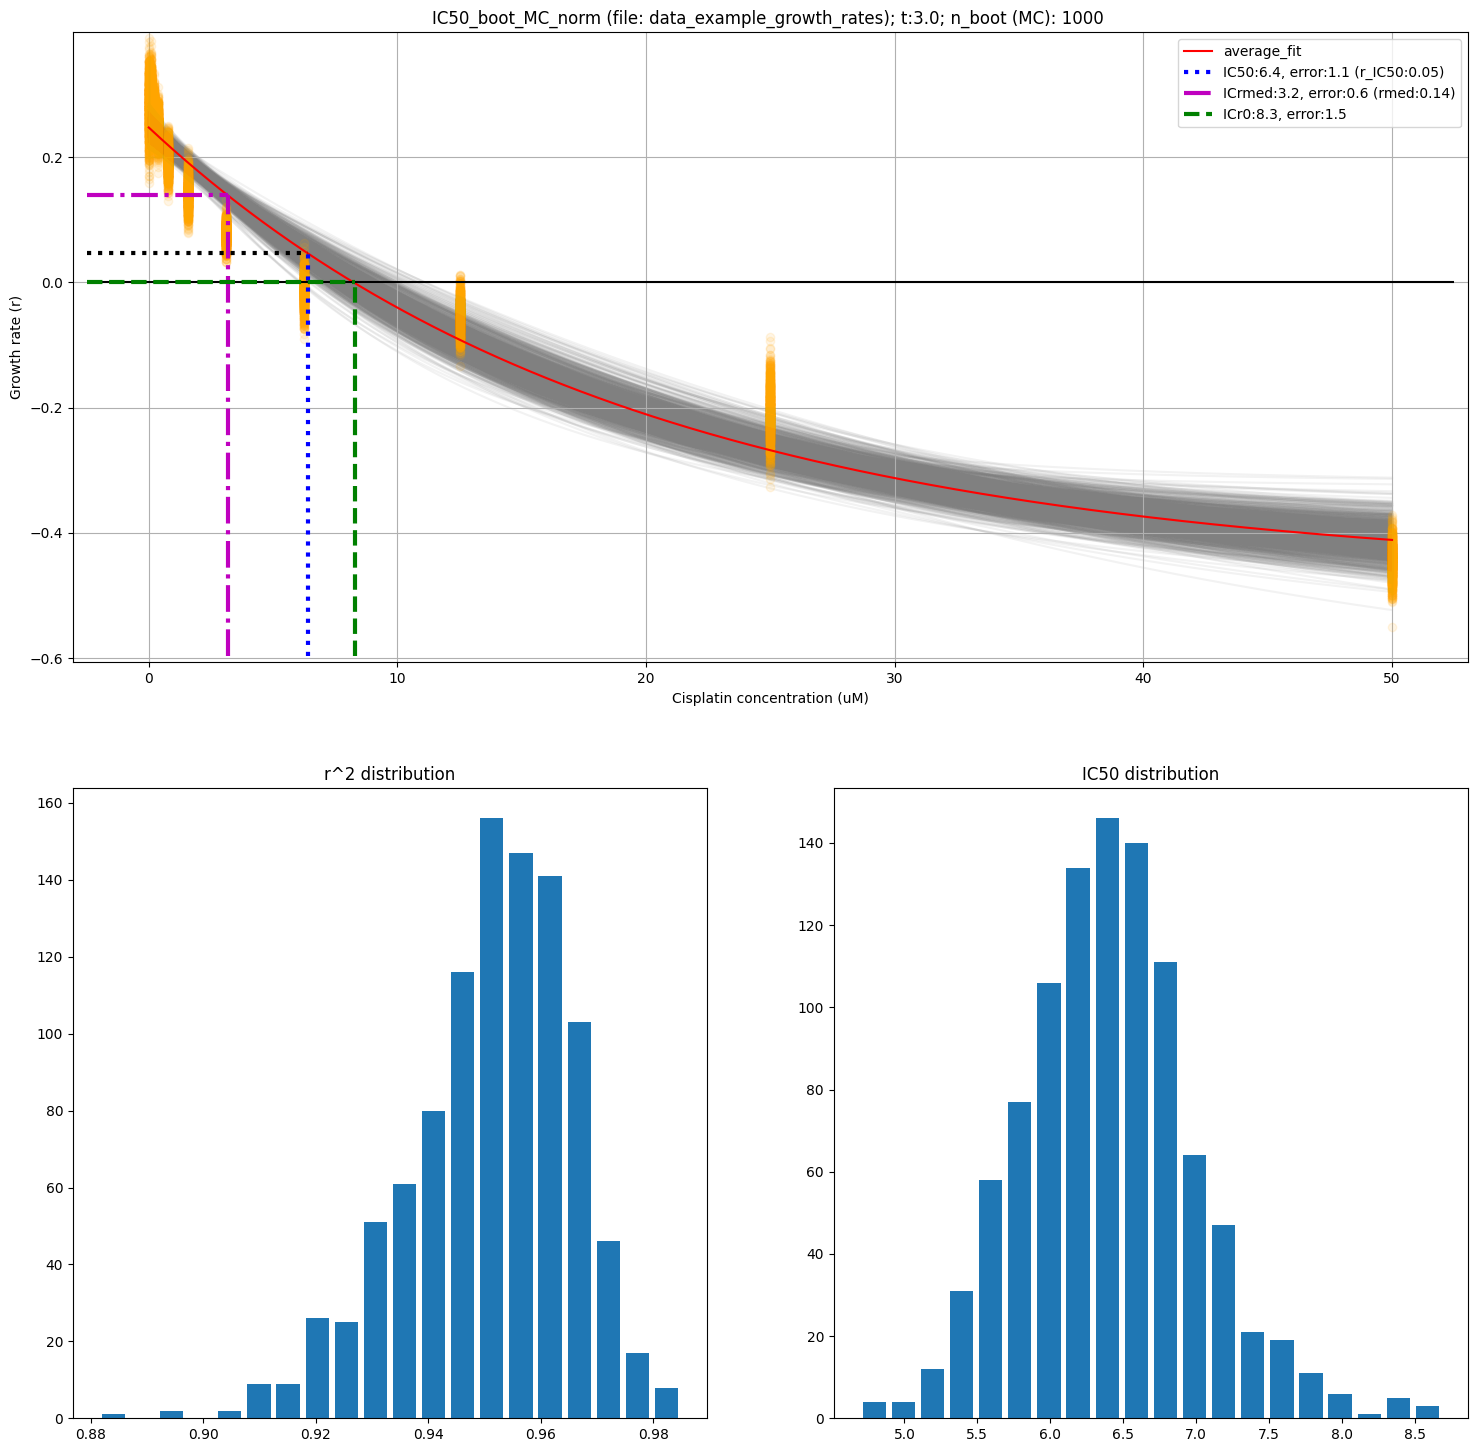

In [14]:
IC50inv_mean, Interv_IC50inv, ICr0inv_mean, Interv_ICr0inv, ICrmedinv_mean, Interv_ICrmedinv = \
    ICmetrics_estimation(X0,y0, e, n_boot, n_samples_fit_r, time_IC50, name, save=True)